# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

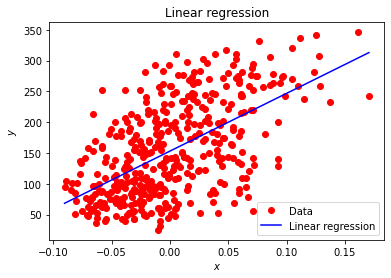

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [3]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [6]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

$$Bias^{2}(\hat{\theta}{S}, \theta) = (E[\hat{\theta}{S}] - \theta)^{2}$$
$$ = E^{2}[\hat{\theta}{S}] + \theta^{2} - 2E[\hat{\theta}{S}]\theta$$

$$Var(\hat{\theta}{S}) = E[\hat{\theta^{2}}{S}] - E^{2}[\hat{\theta}_{S}]$$

$$E[(\hat{\theta}_{S}-\theta)^{2}] = E[\hat{\theta^{2}}_S] + \theta^{2} - 2E[\hat{\theta}_S]\theta$$

$$MSE = E[(\hat{\theta}{S}-\theta)^{2}] = Bias^{2}(\hat{\theta}{S}, \theta) + Var(\hat{\theta}_{S})$$

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

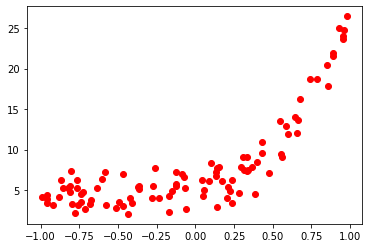

In [7]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

Distribution of the datasets: (shapes)
X train: (80, 1), y train: (80, 1)
X test: (20, 1), y test: (20, 1)

Tuning hyper-parameter for negative MSE - less negative score is better
Best parameter: {'polynomialfeatures__degree': 6}, with score: -0.066877
Grid score:
-0.405 (+/- 0.107) for {'polynomialfeatures__degree': 1}

-0.106 (+/- 0.059) for {'polynomialfeatures__degree': 2}

-0.067 (+/- 0.036) for {'polynomialfeatures__degree': 3}

-0.068 (+/- 0.042) for {'polynomialfeatures__degree': 4}

-0.067 (+/- 0.043) for {'polynomialfeatures__degree': 5}

-0.067 (+/- 0.043) for {'polynomialfeatures__degree': 6}

-0.068 (+/- 0.045) for {'polynomialfeatures__degree': 7}

-0.068 (+/- 0.046) for {'polynomialfeatures__degree': 8}

-0.070 (+/- 0.045) for {'polynomialfeatures__degree': 9}

-0.073 (+/- 0.046) for {'polynomialfeatures__degree': 10}


Applying the model to an independent test set:
Polynominal order used: 6, MSE obtained: 0.066899





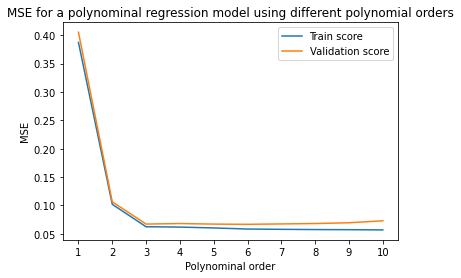

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

X_train = X[:-20, np.newaxis]
y_train = y[:-20, np.newaxis]
X_test = X[-20:, np.newaxis]
y_test = y[-20:, np.newaxis]

print("Distribution of the datasets: (shapes)")
print("X train: {}, y train: {}\nX test: {}, y test: {}\n".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

scaler = StandardScaler()
scaler.fit(X_train)
scalery = StandardScaler()
scalery.fit(y_train)

X_train_scaled = scaler.transform(X_train)
y_train_scaled = scalery.transform(y_train)
X_test_scaled = scaler.transform(X_test)
y_test_scaled = scalery.transform(y_test)

polyreg=make_pipeline(PolynomialFeatures(),LinearRegression())

orders = range(1,11) 
tune_parameter = [{'polynomialfeatures__degree': orders}] 
score = 'neg_mean_squared_error'
print("Tuning hyper-parameter for negative MSE - less negative score is better")
clf = GridSearchCV(polyreg, tune_parameter, scoring=score, return_train_score=True, cv=5)
clf.fit(X_train_scaled.reshape(-1,1), y_train_scaled)

print("Best parameter: {}, with score: {}".format(clf.best_params_, round(clf.best_score_,6)))
print_grid = True
if print_grid:
    print("Grid score:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/- %0.03f) for %r\n" % (mean, std * 2, params))

#Obtain the final degree from the gridsearch and score on the independent test dataset
print("\nApplying the model to an independent test set:")
final_degree = clf.best_params_['polynomialfeatures__degree']
test_score = clf.score(X_test_scaled.reshape(-1,1), y_test_scaled)
print("Polynominal order used: {}, MSE obtained: {}".format(final_degree, abs(round(test_score, 6))))

#Make a plot
print('\n\n')
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score'] 

#Make a plot using the absolute value for MSE - lower is then better (more intuitive)
test_scores_abs = abs(test_scores)
train_scores_abs = abs(train_scores)
plt.plot(orders, train_scores_abs, label='Train score')
plt.plot(orders, test_scores_abs, label='Validation score') 
plt.title('MSE for a polynominal regression model using different polynomial orders')
plt.xlabel('Polynominal order')
plt.ylabel('MSE')
plt.xticks(orders)
plt.legend(loc='best')
# plt.grid() #I used this to help answer the question
plt.show()

**Answer:** Models with high bias and low variance are there where the training and testing scores are close, so up until polynomial order 4, Models with high variance and low bias are there where the training and testing scores are further apart, starting from polynomial order 6.

Distribution of the datasets: (shapes)
X train: (422, 1), y train: (422, 1)
X test: (20, 1), y test: (20, 1)

Tuning hyper-parameter for negative MSE - less negative score is better
Best parameter: {'polynomialfeatures__degree': 6}, with score: -0.664708
Grid score:
-0.667 (+/- 0.043) for {'polynomialfeatures__degree': 1}

-0.675 (+/- 0.059) for {'polynomialfeatures__degree': 2}

-0.675 (+/- 0.059) for {'polynomialfeatures__degree': 3}

-0.679 (+/- 0.073) for {'polynomialfeatures__degree': 4}

-0.673 (+/- 0.059) for {'polynomialfeatures__degree': 5}

-0.665 (+/- 0.045) for {'polynomialfeatures__degree': 6}

-0.669 (+/- 0.053) for {'polynomialfeatures__degree': 7}

-0.730 (+/- 0.228) for {'polynomialfeatures__degree': 8}

-0.715 (+/- 0.151) for {'polynomialfeatures__degree': 9}

-1.464 (+/- 2.987) for {'polynomialfeatures__degree': 10}


Applying the model to an independent test set:
Polynominal order used on diabetes dataset: 6, MSE obtained: 0.466879





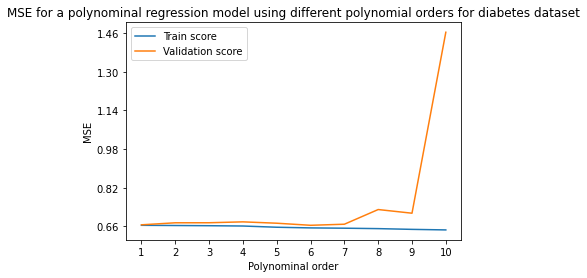

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X_dia = diabetes.data[:, np.newaxis, 2]
y_dia = diabetes.target[:, np.newaxis]

# split the data into training/testing sets
X_train_dia = X_dia[:-20]
X_test_dia = X_dia[-20:]

# split the targets into training/testing sets 
y_train_dia = y_dia[:-20]
y_test_dia = y_dia[-20:]

print("Distribution of the datasets: (shapes)")
print("X train: {}, y train: {}\nX test: {}, y test: {}\n".format(X_train_dia.shape, y_train_dia.shape, X_test_dia.shape, y_test_dia.shape))

scaler_dia = StandardScaler()
scaler_dia.fit(X_train_dia)
scalery_dia = StandardScaler()
scalery_dia.fit(y_train_dia)

X_train_dia_scaled = scaler_dia.transform(X_train_dia)
y_train_dia_scaled = scalery_dia.transform(y_train_dia)
X_test_dia_scaled = scaler_dia.transform(X_test_dia)
y_test_dia_scaled = scalery_dia.transform(y_test_dia)

polyreg=make_pipeline(PolynomialFeatures(),LinearRegression())

orders = range(1,11)
tune_parameter = [{'polynomialfeatures__degree': orders}]
score = 'neg_mean_squared_error'
print("Tuning hyper-parameter for negative MSE - less negative score is better")
clf_dia = GridSearchCV(polyreg, tune_parameter, scoring=score, return_train_score=True, cv=5)
clf_dia.fit(X_train_dia_scaled.reshape(-1,1), y_train_dia_scaled)

print("Best parameter: {}, with score: {}".format(clf_dia.best_params_, round(clf_dia.best_score_, 6)))
print_grid = True
if print_grid:
    print("Grid score:")
    means = clf_dia.cv_results_['mean_test_score']
    stds = clf_dia.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_dia.cv_results_['params']):
        print("%0.3f (+/- %0.03f) for %r\n" % (mean, std * 2, params))

#Obtain the final degree from the gridsearch and score on the independent test dataset
print("\nApplying the model to an independent test set:")
final_degree_dia = clf_dia.best_params_['polynomialfeatures__degree']
test_score_dia = clf_dia.score(X_test_dia_scaled.reshape(-1,1), y_test_dia_scaled)
print("Polynominal order used on diabetes dataset: {}, MSE obtained: {}".format(final_degree_dia, abs(round(test_score_dia, 6))))

#Make a plot
print('\n\n')
test_scores_dia = clf_dia.cv_results_['mean_test_score']
train_scores_dia = clf_dia.cv_results_['mean_train_score'] 

max_y = round(max(test_scores_dia),2)
min_y = round(min(test_scores_dia),2)
stepsize = (max_y - min_y) / 5

#Make a plot using the absolute value for MSE - lower is then better (more intuitive)
test_scores_dia_abs = abs(test_scores_dia)
train_scores_dia_abs = abs(train_scores_dia)

max_y = round(max(test_scores_dia_abs),2)
min_y = round(min(test_scores_dia_abs),2)
stepsize = (max_y - min_y) / 5

plt.plot(orders, train_scores_dia_abs, label='Train score')
plt.plot(orders, test_scores_dia_abs, label='Validation score') 
plt.title('MSE for a polynominal regression model using different polynomial orders for diabetes dataset')
plt.xlabel('Polynominal order')
plt.ylabel('MSE')
plt.xticks(orders)
plt.yticks(np.arange(min_y, max_y + 0.01, stepsize))
plt.legend(loc='best')
# plt.grid() #I used this to help answer the question
plt.show()

**Answer:** Models with high bias and low variance are where the training and testing scores are close, so up until polynomial order 6. Models with high variance and low bias are where the training and testing scores are further apart, starting from polynomial order 8.

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

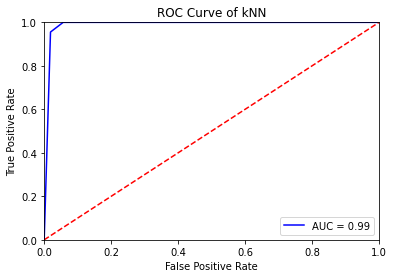

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=2)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


import numpy as np
from sklearn import metrics
from sklearn.metrics import auc
import matplotlib.pyplot as plt

y_score = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)

#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import auc

def ROC(k):


    breast_cancer = datasets.load_breast_cancer()

    X = breast_cancer.data
    y = breast_cancer.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

    

    knn = neighbors.KNeighborsClassifier(n_neighbors=k)

    model = Pipeline([
                     ("scaler", scaler),
                     ("knn", knn)
                    ])

    # train the model using the training dataset
    model.fit(X_train, y_train)

    # make predictions using the testing dataset
    prediction = model.predict(X_test)


    y_score = model.predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])

    roc_auc = auc(fpr, tpr)
    return roc_auc, fpr, tpr

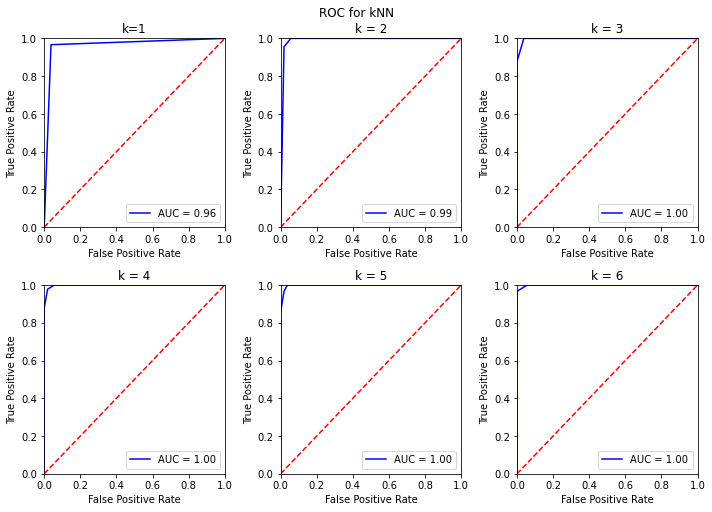

<Figure size 432x288 with 0 Axes>

In [34]:
roc_auc1, fpr1, tpr1 = ROC(1)
plt.figure(figsize = (10,7))
plt.subplot(2,3,1)

plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('k=1')
plt.tight_layout()

roc_auc2, fpr2, tpr2 = ROC(2)

plt.subplot(2,3,2)
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('k = 2')
plt.tight_layout()

roc_auc3, fpr3, tpr3 = ROC(3)

plt.subplot(2,3,3)
plt.plot(fpr3, tpr3, 'b', label = 'AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('k = 3')
#plt.tight_layout()

roc_auc4, fpr4, tpr4 = ROC(4)

plt.subplot(2,3,4)
plt.plot(fpr4, tpr4, 'b', label = 'AUC = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('k = 4')
plt.tight_layout()

roc_auc5, fpr5, tpr5 = ROC(5)
plt.subplot(2,3,5)
plt.plot(fpr5, tpr5, 'b', label = 'AUC = %0.2f' % roc_auc5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('k = 5')
plt.tight_layout()

roc_auc6, fpr6, tpr6 = ROC(6)
plt.subplot(2,3,6)
plt.plot(fpr6, tpr6, 'b', label = 'AUC = %0.2f' % roc_auc6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('k = 6')
plt.suptitle('ROC for kNN', y =1.01)

plt.show()
plt.tight_layout()

print()

***Answer***: ORIGINAL ANSWER::Only the ROC plot for k = 2 deviates from the rest.
MAYBE CHANGE TO: The ROC curves for k = 1 and k = 2 deviate from the rest of the ROC plots made. The AUC scores of k = 3, 4, 5 and 6, are all 1 and thus for these range of k, perform the best. k = 1 has the ''worst'' AUC score of 0.96, although still performing relatively well. 

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


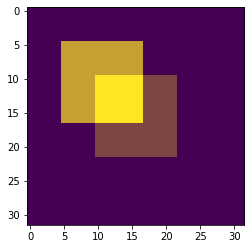

In [35]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

In [36]:
TP = 0
FP = 0
FN = 0
for i in range(len(A[1,:])):
    for j in range(len(A[1,:])):
        if A[i,j] == 1 and B[i,j] == 1:
            TP = TP + 1
        if A[i,j] == 0 and B[i,j] == 1:
            FP = FP + 1
        if A[i,j] == 1 and B[i,j] == 0:
            FN = FN + 1
precision = TP/(TP+FP)
recall = TP/(TP+FN)

F_1 = 2*(precision*recall)/(precision+recall)
print(F_1)

0.3402777777777778


<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>